In [2]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pyarrow
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

# General behavior of freely swimming fish


In [135]:
df_tracking = pl.scan_csv("../data/20250702_tracking.csv").collect()
df_VR = pl.scan_csv("../data/20250702_VR.csv").collect()
df_CB = pd.read_pickle("../data/external/Anneser2022/CollectiveBehavior_df.pkl")
df_CB_traj = pd.read_pickle("../data/external/Anneser2022/CollectiveBehavior_TrajectoriesOnly.pkl")

a = np.inf 
# df_CB.replace(a, np.nan, inplace=True) # switch inf to nan
genotypes = df_CB.index[[0]].levels[0][:] # get the list of genotypes (pth2-/- and pth2+/+)
cm_conversion = 100 / 49.624 # conversion factor to compute all values in cm instead of pixels
time = np.linspace(0,30,1799)  # for downsampling to 1 Hz

# extract velocity from dataset (easier indexing)
vel_df = df_CB['velocity'].apply(pd.Series).transpose()
# replace infs with nans
vel_df.replace(a, np.nan, inplace=True)
# convert to cm/sec
vel_df = vel_df/(30*cm_conversion) 


In [136]:
vel_df_wildtype = vel_df["$pth2^{+/+}$"]
stats_df = vel_df_wildtype.describe().T


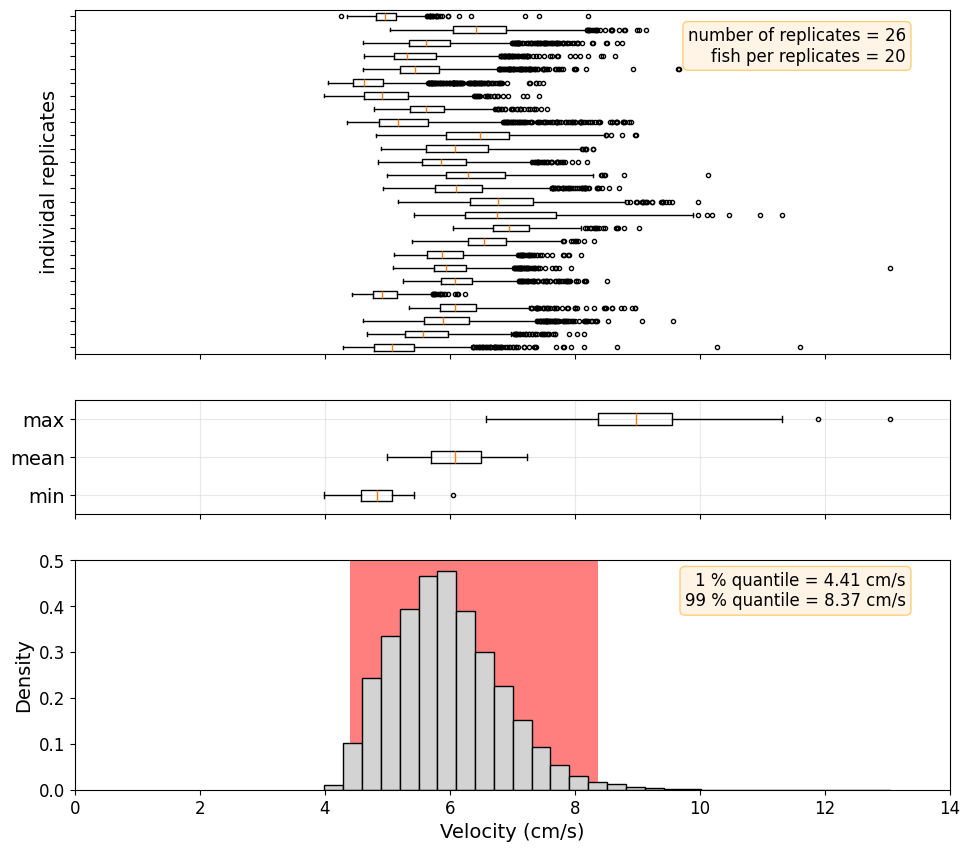

In [152]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 12), height_ratios=[3, 1, 2])
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
ax1.boxplot(vel_df_wildtype.dropna(), orientation="horizontal", notch=False, sym='.', whis=1.5)
ax1.set_xlabel("")
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_ylabel("individal replicates", fontsize=14)
ax1.set_xlim(0, 14)

# add text box for the statistics
stats = (f'number of replicates = {vel_df_wildtype.shape[1]}\n'
         f'fish per replicates = 20'
         )
         #f'$\\sigma$ = {np.std(y):.2f}\n'
         #f'$r$ = {np.corrcoef(x, y)[0][1]:.2f}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax1.text(0.95, 0.85, stats, fontsize=12, bbox=bbox,
        transform=ax1.transAxes, horizontalalignment='right')

bp = ax2.boxplot(stats_df[["min", "mean", "max"]], orientation="horizontal", notch=False, sym='.',whis=1.5)

ax2.set_yticklabels(["min", "mean", "max"], fontsize=14)
ax2.set_xticklabels([])
ax2.set_xlabel("")

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax2.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax2.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax2.set_xlim(0, 14)


merged = pd.Series(vel_df_wildtype.dropna().values.ravel())
s = pl.Series("values", merged)
lower = s.quantile(0.01, interpolation="linear")
upper = s.quantile(0.99, interpolation="linear")
plt.axvspan(lower, upper, color='r', alpha=0.5, lw=0)
ax3.hist(merged, bins=30, density=True, color='lightgrey', edgecolor='black')
ax3.set_xlim(0, 14)
ax3.set_xlabel("Velocity (cm/s)", fontsize=14)
ax3.set_ylabel("Density", fontsize=14)
ax3.tick_params(axis='both', labelsize=12)
#ax.tick_params(axis='both', which='minor', labelsize=10)

# add text box for the statistics
stats = (f'1 % quantile = {lower:.2f} cm/s\n'
         f'99 % quantile = {upper:.2f} cm/s'
         )
         #f'$\\sigma$ = {np.std(y):.2f}\n'
         #f'$r$ = {np.corrcoef(x, y)[0][1]:.2f}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax3.text(0.95, 0.80, stats, fontsize=12, bbox=bbox,
        transform=ax3.transAxes, horizontalalignment='right')

plt.savefig("../results/misc/empirical_velocity.png")

Text(1.12, 0.1, '52.99 % below 4.41 cm/s\n28.74 % above 8.37 cm/s')

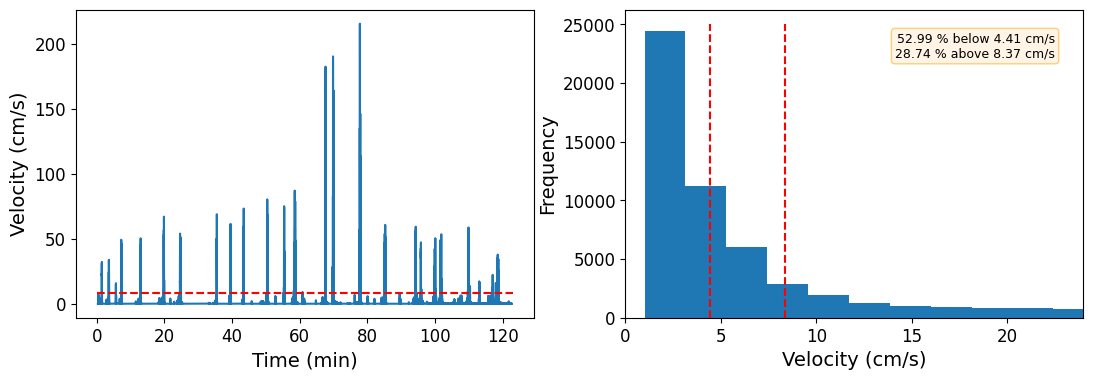

In [161]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
ax1.plot(df_VR.select(pl.col("timestamp"))/60, df_VR.select(pl.col("velocity")*100))
ax1.hlines(8.37, 0, 123, colors="red", linestyles="dashed")
ax1.set_xlabel("Time (min)", fontsize=14)
ax1.set_ylabel("Velocity (cm/s)", fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

ax2.hist(df_VR.filter(pl.col("velocity")*100 > 1 ).select(pl.col("velocity")*100), bins=100)
ax2.vlines((4.41, 8.37), 0, 25000, colors="red", linestyles="dashed")
ax2.set_xlim(0, 24)
ax2.set_xlabel("Velocity (cm/s)", fontsize=14)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.tick_params(axis='both', labelsize=12)

# add text box for the statistics
percentage_below = len(df_VR.filter(
    (pl.col("velocity")*100 > 1) & 
    (pl.col("velocity")*100 <= 4.41)
)) / len(df_VR.filter(
    (pl.col("velocity")*100 > 1))) * 100 

percentage_above = len(df_VR.filter(
    (pl.col("velocity")*100 > 8.37) 
)) / len(df_VR.filter(
    (pl.col("velocity")*100 > 1))) * 100 

stats = (f'{percentage_below:.2f} % below {lower:.2f} cm/s\n'
         f'{percentage_above:.2f} % above {upper:.2f} cm/s'
         )

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax2.text(1.12, 0.1, stats, fontsize=9, bbox=bbox,
        transform=ax3.transAxes, horizontalalignment='right')

A way to keep values from exceeding the empirical distribution too much is to softly clamp them. This can be done by using the empirical distribution to define a soft threshold, which is then used to adjust the values.

In [139]:
def soft_clamp(v_input: float, v_max: float=8.37, softness: float=0.5) -> float:
    """
    Softly clamps v_input to not significantly exceed v_max.
    
    Parameters:
    - v_input: velocity (float)
    - v_max: max velocity (float), defaults to 8.37
    - softness: smaller = harder clamp; larger = softer, defaults to 0.5
    
    Returns:
    - soft-clamped velocity
    """
    if v_input <= v_max:
        return v_input
    else:
        excess = v_input - v_max
        return v_max + softness * np.tanh(excess / softness)

df_VR = df_VR.with_columns((pl.col("velocity")*100).map_elements(soft_clamp).alias("clamped_velocity"))

df_VR

C:\Users\anneluka\AppData\Local\Temp\ipykernel_19980\3089013163.py:19: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_VR = df_VR.with_columns((pl.col("velocity")*100).map_elements(soft_clamp).alias("clamped_velocity"))


trial,trial index,2p framecount,timestamp,xpos,ypos,heading,velocity,dheading,2p state,optic flow state,optic flow direction,optic flow velocity,stim state,stim state pulsed,tail tracking framecount,vr gain,inactivity timer,clamped_velocity
i64,i64,f64,f64,f64,f64,f64,f64,f64,bool,bool,i64,f64,bool,bool,i64,f64,f64,f64
0,0,0.0,19.933446,-1.0,0.0,0.0,0.0,-0.0,false,false,0,-1.0,false,false,5670,1.0,0.0,0.0
0,0,0.0,19.954677,-1.0,0.0,0.0,0.0,-0.0,false,false,0,-1.0,false,false,5672,1.0,0.021231,0.0
0,0,0.0,20.029999,-1.0,0.0,0.0,0.0,-0.0,false,false,0,-1.0,false,false,5679,1.0,0.096553,0.0
0,0,0.0,20.348389,-1.0,0.0,0.0,0.0,-0.0,false,false,0,-1.0,false,false,5710,1.0,0.414942,0.0
0,0,0.0,20.365148,-1.0,0.0,0.0,0.0,-0.0,false,false,0,-1.0,false,false,5711,1.0,0.431701,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65,58,0.0,7357.178426,0.0,0.064832,0.0,0.000761,-0.0,true,false,0,-1.0,false,false,737117,1.0,0.0,0.076131
65,58,0.0,7357.189537,0.0,0.06484,0.0,0.000751,-0.0,true,false,0,-1.0,false,false,737119,1.0,0.0,0.075138
65,58,0.0,7357.200648,0.0,0.064848,0.0,0.000732,-0.0,true,false,0,-1.0,false,false,737121,1.0,0.0,0.07319


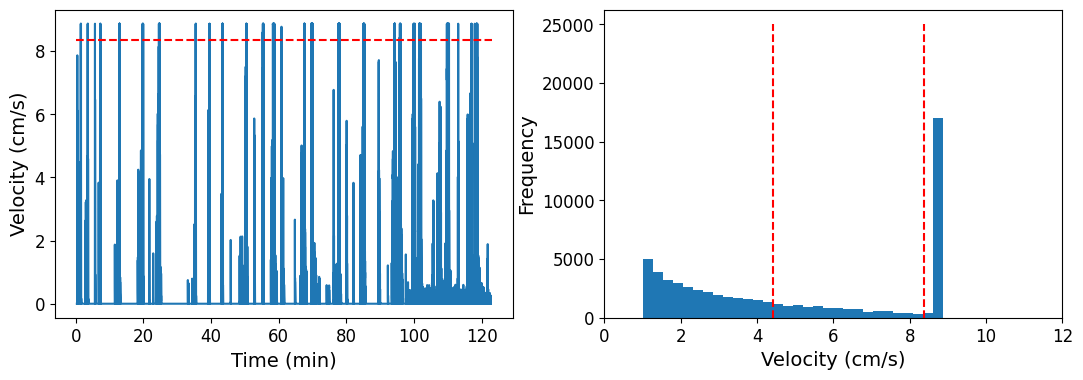

In [166]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
ax1.plot(df_VR.select(pl.col("timestamp"))/60, df_VR.select(pl.col("clamped_velocity")))
ax1.hlines(8.37, 0, 123, colors="red", linestyles="dashed")
ax1.set_xlabel("Time (min)", fontsize=14)
ax1.set_ylabel("Velocity (cm/s)", fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

ax2.hist(df_VR.filter(pl.col("velocity")*100 > 1 ).select(pl.col("clamped_velocity")), bins=30)
ax2.vlines((4.41, 8.37), 0, 25000, colors="red", linestyles="dashed")
ax2.set_xlim(0, 12)
ax2.set_xlabel("Velocity (cm/s)", fontsize=14)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.tick_params(axis='both', labelsize=12)

# add text box for the statistics
percentage_below = len(df_VR.filter(
    (pl.col("clamped_velocity") > 1) & 
    (pl.col("clamped_velocity") <= 4.41)
)) / len(df_VR.filter(
    (pl.col("clamped_velocity") > 1))) * 100 

percentage_above = len(df_VR.filter(
    (pl.col("clamped_velocity") > 8.37) 
)) / len(df_VR.filter(
    (pl.col("clamped_velocity") > 1))) * 100 

stats = (f'{percentage_below:.2f} % below {lower:.2f} cm/s\n'
         f'{percentage_above:.2f} % above {upper:.2f} cm/s'
         )

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
# ax2.text(0.99, 0.1, stats, fontsize=9, bbox=bbox,
#        transform=ax3.transAxes, horizontalalignment='right')

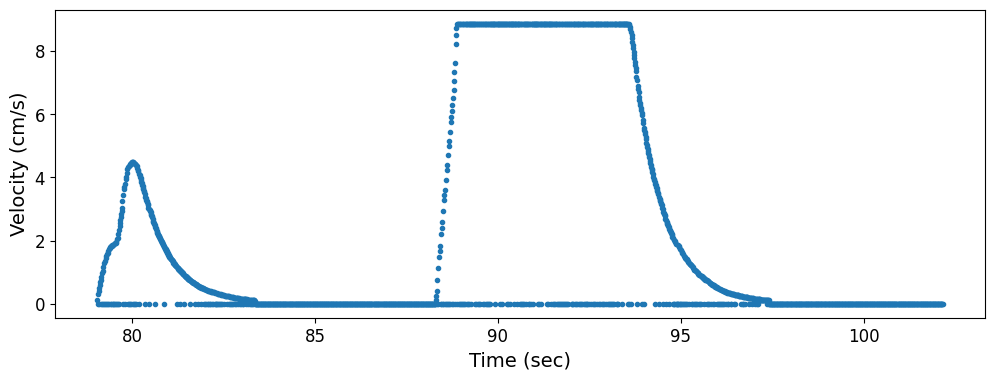

In [167]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_VR[5000:7000].select(pl.col("timestamp")), df_VR[5000:7000].select(pl.col("clamped_velocity")), '.')
ax1.set_xlabel("Time (sec)", fontsize=14)
ax1.set_ylabel("Velocity (cm/s)", fontsize=14)
ax1.tick_params(axis="both", labelsize=12)

In [126]:
columns_to_convert = [col for col in df_tracking.columns if col.startswith("pt_")]

# Perform transformation natively with Polars expressions
df = df_tracking.with_columns([
    pl.col(col)
    .str.extract_all(r"\d+")
    .list.eval(pl.element().cast(pl.Int32))
    .alias(col)
    for col in columns_to_convert
])

In [127]:
angle_exprs = [
    pl.arctan2(
        pl.col(f"pt_{i+1}").list.get(1) - pl.col(f"pt_{i}").list.get(1),
        pl.col(f"pt_{i+1}").list.get(0) - pl.col(f"pt_{i}").list.get(0)
    ).alias(f"angle_{i}")
    for i in range(7)  # 0 to 6
]
df = df.with_columns(angle_exprs)

In [128]:
angle_cols = [col for col in df.columns if col.startswith("angle_")]

df = df.with_columns(
    pl.sum_horizontal([pl.col(c) for c in angle_cols]).alias("summed_angle")
)
df

framecount,velocity,heading,gain_v,gain_h,threshold_v,threshold_h,cumulative tail angle,offset,pt_0,pt_1,pt_2,pt_3,pt_4,pt_5,pt_6,pt_7,angle_0,angle_1,angle_2,angle_3,angle_4,angle_5,angle_6,summed_angle
i64,f64,f64,f64,f64,f64,f64,f64,f64,list[i32],list[i32],list[i32],list[i32],list[i32],list[i32],list[i32],list[i32],f64,f64,f64,f64,f64,f64,f64,f64
953,0.0,0.0,0.001,1.0000e-11,0.001,1.0,-0.6274,0.0,"[0, 124]","[24, 127]","[45, 113]","[69, 114]","[93, 116]","[117, 116]","[141, 114]","[165, 109]",0.124355,-0.588003,0.041643,0.083141,0.0,-0.083141,-0.205395,-0.6274
958,0.0,0.0,0.001,1.0000e-11,0.001,1.0,-0.6274,-0.3137,"[0, 124]","[24, 127]","[45, 113]","[69, 114]","[93, 116]","[117, 116]","[141, 114]","[165, 109]",0.124355,-0.588003,0.041643,0.083141,0.0,-0.083141,-0.205395,-0.6274
960,0.0,0.0,0.001,1.0000e-11,0.001,1.0,-0.6274,-0.6274,"[0, 124]","[24, 127]","[45, 113]","[69, 114]","[93, 116]","[117, 116]","[141, 114]","[165, 109]",0.124355,-0.588003,0.041643,0.083141,0.0,-0.083141,-0.205395,-0.6274
961,0.0,0.0,0.001,1.0000e-11,0.001,1.0,-0.6274,-0.6274,"[0, 124]","[24, 127]","[45, 113]","[69, 114]","[93, 116]","[117, 116]","[141, 114]","[165, 109]",0.124355,-0.588003,0.041643,0.083141,0.0,-0.083141,-0.205395,-0.6274
962,0.0,0.0,0.001,1.0000e-11,0.001,1.0,-0.6274,-0.6274,"[0, 124]","[24, 127]","[45, 113]","[69, 114]","[93, 116]","[117, 116]","[141, 114]","[165, 109]",0.124355,-0.588003,0.041643,0.083141,0.0,-0.083141,-0.205395,-0.6274
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
737799,0.000232,0.0,0.002317,1.0000e-11,0.000052,1.0,-0.410791,-0.246256,"[2, 123]","[26, 121]","[50, 122]","[74, 121]","[98, 123]","[122, 123]","[146, 118]","[170, 113]",-0.083141,0.041643,-0.041643,0.083141,0.0,-0.205395,-0.205395,-0.410791
737800,0.000228,0.0,0.002317,1.0000e-11,0.000052,1.0,-0.491719,-0.246256,"[2, 123]","[26, 123]","[50, 121]","[74, 119]","[98, 123]","[122, 122]","[146, 118]","[170, 111]",0.0,-0.083141,-0.083141,0.165149,-0.041643,-0.165149,-0.283794,-0.491719
737802,0.000225,0.0,0.002317,1.0000e-11,0.000052,1.0,-0.405849,-0.246256,"[2, 123]","[26, 126]","[50, 124]","[74, 119]","[98, 123]","[122, 125]","[146, 119]","[170, 113]",0.124355,-0.083141,-0.205395,0.165149,0.083141,-0.244979,-0.244979,-0.405849


In [114]:
df_swimming = df.filter(
    pl.col("velocity") > 0

)




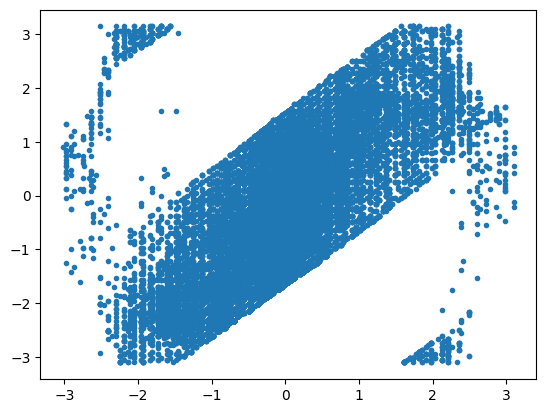

In [169]:
plt.plot(df_swimming["angle_4"], df_swimming["angle_6"], '.')